# Credits to

[1] https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2 

[2] https://www.kaggle.com/ragnar123/very-fst-model

[3] https://www.kaggle.com/mayer79/m5-forecast-poisson-loss

[4] https://www.kaggle.com/sayanotsu/walmart-weekly-sales-aggregation 

# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import gc
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import time
import pickle
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from datetime import datetime, timedelta

In [2]:
LAGS = [7, 28]
WINDOWS = [7,  28]
FIRST = 1914
LENGTH = 28
FOLDS = 3
drop_d = 730 # best to ditch the first two years aka 730

np.random.seed(0)

features = ['month', 'week', 'dept_id', 'snap_CA', 'wday', 'item_id', 'cat_id',
       'snap_TX', 'sell_price', 'lag_t28', 'rolling_mean_lag28_w7',
       'event_type_2', 'event_name_1', 'event_type_1',
       'lag_t7', 'snap_WI', 'sell_price_rel_diff', 'event_name_2', 'year', 'rolling_mean_lag7_w7',
       'rolling_mean_lag7_w28', 'rolling_mean_lag28_w28', 'state_id','store_id']

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]

# 'price_max', 'price_norm', 'price_mean', 'price_std', 'price_min',, 'rolling_mean_lag28_w14','rolling_mean_lag7_w14'

drop = ['id', 'd', 'demand', "date", "sales", "weekday"]

encoder_file = open('encoders', 'wb')

In [3]:
'''
Got from: [1]
'''
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
'''
Got from: [1]
'''
path = "../input/m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = reduce_mem_usage(pd.read_csv(os.path.join(path, "sample_submission.csv")))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [5]:
event_index_1 = calendar.index[calendar['event_name_1'] == calendar['event_name_1']]
event_index_2 = calendar.index[calendar['event_name_2'] == calendar['event_name_2']]
event_index_1_min1 = event_index_1 - 1
event_index_1_min2 = event_index_1 - 2
event_index_2_min1 = event_index_2 - 1
event_index_2_min2 = event_index_2 - 2
calendar.loc[event_index_1_min1, 'event_name_1'] = '1daysbefore'
calendar.loc[event_index_1_min2, 'event_name_1'] = '2daysbefore'
calendar.loc[event_index_2_min1, 'event_name_2'] = '1daysbefore'
calendar.loc[event_index_2_min2, 'event_name_2'] = '2daysbefore'
calendar.loc[event_index_1_min1, 'event_type_1'] = 'buildup'
calendar.loc[event_index_1_min2, 'event_type_1'] = 'buildup'
calendar.loc[event_index_2_min1, 'event_type_2'] = 'buildup'
calendar.loc[event_index_2_min2, 'event_type_2'] = 'buildup'
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
calendar.event_name_1.values

array([nan, nan, nan, ..., '2daysbefore', '1daysbefore', 'NBAFinalsEnd'],
      dtype=object)

In [7]:
'''
Got from: [1]
- The columns "Date" and "Weekday" are dropped as they contain redundant information.
- Normally, the column "d" is like "d_1,d_2,...". Make it "1,2,.." and the type integer
- If there is no event (I think), there is NA. We will replace them with "NoEvent" string. Originally, it was replaced with
  "missing", but I don't think it makes sense as I don't think there is missing information, I think they just left 
  the days without any event as NA.
- We enumerate most of the columns:
    - We do not enumerate "d" and "wm_yr_weak" because we will use these columns for joins.
    - Why do we enumerate month and day? I think it is because they start from 1, not 0.
    - Originally, the binary columns "snap_X" were also enumerated. I don't think it is necessary. The only neccessary step
      was to convert their type from int64 to int as it uses less space; but reduce_mem_usage will take care of that.
- I would suggest saving the OrdinalEncoder in case we need to reverse the transformations
'''
def prep_calendar(df,encoder_file):
    
    # from[4], add week as a column to dataframe 
    df['date'] = pd.to_datetime(df['date'])
    wm_yr_wk_values = np.sort(df['wm_yr_wk'].unique())
    wm_yr_wk_values_new = np.arange(len(wm_yr_wk_values))
    wm_yr_wk_values_replace = dict(zip(wm_yr_wk_values, wm_yr_wk_values_new))
    df['week'] = df['wm_yr_wk'].replace(wm_yr_wk_values_replace).astype('int16')
    del wm_yr_wk_values_replace, wm_yr_wk_values_new, wm_yr_wk_values

    df = df.drop(["weekday"], axis=1)  # date was dropped here
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("NoEvent")
    cols = list(set(df.columns) - {"wm_yr_wk", "d","snap_CA","snap_TX","snap_WI"}) 
    oe = OrdinalEncoder(dtype="int")
    df[cols] = oe.fit_transform(df[cols])
    pickle.dump(oe,encoder_file)
    df = reduce_mem_usage(df)
    return df

'''
Got from: [1]
Originally, there were features added in this part. I excluded them until we decide whether to use those or not.
'''
def prep_selling_prices(df):
    df = reduce_mem_usage(df)
    return df

'''
Got from: [1]
- We drop the first "drop_d" days. Originally, this is set to 1000. When it is set to this value,
  the shape we get 29,544,810 rows. When we don't set it, we get 60,034,810 rows. I think for now 
  we can keep this functionality, as it may be useful if we would like to discard some of the days.
- In some id's, we have "_validation". Those are deleted.
- reindex: Conform DataFrame to new index with optional filling logic (obtained from pandas doc). 
  We add days 1914+2*28 to prepare data from submission
- We have to melt the sales dataframe since days are contained as columns.
- assign: Returns a new object with all original columns in addition to new ones. Existing columns 
  that are re-assigned will be overwritten (obtained from pandas doc). Again, we make the values 
  "d_1, d-2,..." to "1,2,..."
'''
#We have to melt sales for sure because the days are columns, which is not desirable.
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"), demand=df.demand.astype("float32"))
    return df

In [8]:
calendar = prep_calendar(calendar,encoder_file)
selling_prices = prep_selling_prices(selling_prices)
sales = reshape_sales(sales, drop_d)

Mem. usage decreased to  0.03 Mb (83.9% reduction)
Mem. usage decreased to 143.53 Mb (31.2% reduction)


In [9]:
'''
Got from: [1]
- Merge all the dataframes and delete the unnecessary ones
- time.sleep() added to make sure garbage collector finishes its job before the next merge
'''
sales = sales.merge(calendar, how="left", on="d")
del calendar
gc.collect()
time.sleep(5)
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
del selling_prices
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
time.sleep(5)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week,sell_price
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,730,2,...,2,21,2,5,1,0,0,0,104,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,730,2,...,2,21,2,5,1,0,0,0,104,3.97
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,730,2,...,2,21,2,5,1,0,0,0,104,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,731,1.0,730,2,...,2,21,2,5,1,0,0,0,104,4.34
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,731,0.0,730,2,...,2,21,2,5,1,0,0,0,104,3.08


# Encode some variables

In [10]:
'''
Got from: [1]
- We will also save the encoders in the pickle file.
- The loop is slightly changed
'''

cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]

# In loop to minimize memory use
for col in cat_id_cols:
    oe = OrdinalEncoder(dtype="int")
    sales[col] = oe.fit_transform(sales[[col]])
    pickle.dump(oe,encoder_file)    
sales = reduce_mem_usage(sales)
gc.collect()

Mem. usage decreased to 1657.24 Mb (42.5% reduction)


0

In [11]:
'''
Got from: [1]
- These features were originally added in prep_selling_prices function to the 
  selling_prices dataframe, which does not exist anymore. But we can use the same
  code to add these to sales dataframe as well as the columns are the same.
- New feature="sell_price_rel_diff"
  pct_change(): Computes the percentage change from the immediately previous row by default. (Obtained from pandas doc.)
  The two lines below adds the percentage of change of each item that is sold in the stores. Of course, for the
  first datapoint, there is no previous, so this code produces an NA. Since there are 3049x10=30490 different (item,store)
  pairs, this new column has 30490 NAs.
- New feature="sell_price_roll_sd7"
  Rolling standard deviation: Moving Standard Deviation is a statistical measurement of market volatility (Google). We check the
  past 7 days.
- New feature="sell_price_cumrel"
  I think this is cumulative related frequency. I am not sure and I did not understand it clearly. I think
  it is some kind of normalization, because we subtract the minimum and divide by max-min+1.
- It runs without problems, but the RAM gets almost filled up so it gives you a heart attack.
- No need to call reduce_mem_usage() after as I tried and it did not save any additional space.
'''

gr = sales.groupby(["store_id", "item_id"])["sell_price"]
sales["sell_price_rel_diff"] = gr.pct_change()
#sales["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())

del gr
gc.collect()

26

In [12]:
def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
            
            
        date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }
    
    df["date"] = pd.to_datetime(df["date"])
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

In [13]:
'''
Got from: [1]
Appearantly, [1] derived the features from [2].

- The features include rolling means and standard deviations for different number of days.
  I think this is also a measure of market volatiliy.
- After this, original notebook deletes rows producing NAs. 'rolling_mean_t180' produces the most NAs as I
  believe the value of first 180 days will be NA because to compute this we need 180 days prior. I do not 
  know whether adding these features is so important to delete that much data. Hence, I will keep it for now.
  I think time ranges can also be changed.
'''

#gr = sales.groupby(["id"])["demand"]
#sales['lag_t28'] = gr.transform(lambda x: x.shift(28))
#sales['rolling_mean_t7'] = gr.transform(lambda x: x.shift(28).rolling(7).mean())
#sales['rolling_mean_t30'] = gr.transform(lambda x: x.shift(28).rolling(30).mean())
#sales['rolling_mean_t60'] = gr.transform(lambda x: x.shift(28).rolling(60).mean())
#sales['rolling_mean_t90'] = gr.transform(lambda x: x.shift(28).rolling(90).mean())
#sales['rolling_mean_t180'] = gr.transform(lambda x: x.shift(28).rolling(180).mean())
#sales['rolling_std_t7'] = gr.transform(lambda x: x.shift(28).rolling(7).std())
#sales['rolling_std_t30'] = gr.transform(lambda x: x.shift(28).rolling(30).std())


# lora's custom features

#sales['price_max'] = gr.transform('max')
#sales['price_min'] = gr.transform('min')
#sales['price_std'] = gr.transform('std')
#sales['price_mean'] = gr.transform('mean')
#sales['price_norm'] = sales['sell_price']/sales['price_max']
#sales['price_momentum'] =   sales['sell_price']/gr.transform(lambda x: x.shift(1))
#sales['price_momentum_m'] = sales['sell_price']/gr.transform('mean')
#sales['price_momentum_y'] = sales['sell_price']/gr.transform('mean')

#del gr
#sales = reduce_mem_usage(sales)
#gc.collect()


"\nGot from: [1]\nAppearantly, [1] derived the features from [2].\n\n- The features include rolling means and standard deviations for different number of days.\n  I think this is also a measure of market volatiliy.\n- After this, original notebook deletes rows producing NAs. 'rolling_mean_t180' produces the most NAs as I\n  believe the value of first 180 days will be NA because to compute this we need 180 days prior. I do not \n  know whether adding these features is so important to delete that much data. Hence, I will keep it for now.\n  I think time ranges can also be changed.\n"

In [14]:
sales = demand_features(sales)
sales = sales[sales.d > (drop_d + max(LAGS) + max(WINDOWS))]
sales = reduce_mem_usage(sales)
gc.collect()

Mem. usage decreased to 2820.69 Mb (5.7% reduction)


29

In [15]:
x = list(set(sales.columns) - {'id', 'd', 'demand', "date", "sales", "weekday"}) # dropped date, sales and weekday as they don't contribute much
test = sales[sales.d >= FIRST - max(LAGS) - max(WINDOWS)] # add windows needed to provide test features
sales = sales[sales.d < FIRST]
labels = sales['demand']
sales = sales[x]
encoder_file.close()
gc.collect()

0

In [16]:
fake_valid_inds = np.random.choice(sales.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(sales.index.values, fake_valid_inds)
cat_feats = [sales.columns.get_loc(c) for c in cat_feats if c in sales]

sales_x = sales.loc[train_inds].values.astype(np.float32)
sales_x_val = sales.loc[fake_valid_inds].values.astype(np.float32)
del sales
sales_y = labels.loc[train_inds].values.astype(np.float32)
sales_y_val = labels.loc[fake_valid_inds].values.astype(np.float32)
del labels
gc.collect()


train_data = lgb.Dataset(sales_x , label = sales_y, 
                         categorical_feature=cat_feats, 
                         free_raw_data=False)
fake_valid_data = lgb.Dataset(sales_x_val, label = sales_y_val,
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!
del train_inds, fake_valid_inds, sales_x, sales_x_val, sales_y, sales_y_val
gc.collect()


0

In [17]:
def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
                'boosting_type': 'gbdt',
                'objective': 'tweedie',
                'tweedie_variance_power': 1.1,
                'metric': 'rmse',
                'subsample': 0.5,
                'subsample_freq': 1,
                'learning_rate': 0.031,
                'num_leaves': 2**11-1,
                'min_data_in_leaf': 2**12-1,
                'feature_fraction': 0.5,
                'max_bin': 100,
                'n_estimators': 800,
                'boost_from_average': False,
                'verbose': -1,
                'seed': 0
                } 

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 2000, # should be 2000
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.30403
[200]	valid_0's rmse: 2.25029
[300]	valid_0's rmse: 2.22397
[400]	valid_0's rmse: 2.20691
[500]	valid_0's rmse: 2.19411
[600]	valid_0's rmse: 2.18234
[700]	valid_0's rmse: 2.17372
[800]	valid_0's rmse: 2.16632
Did not meet early stopping. Best iteration is:
[800]	valid_0's rmse: 2.16632


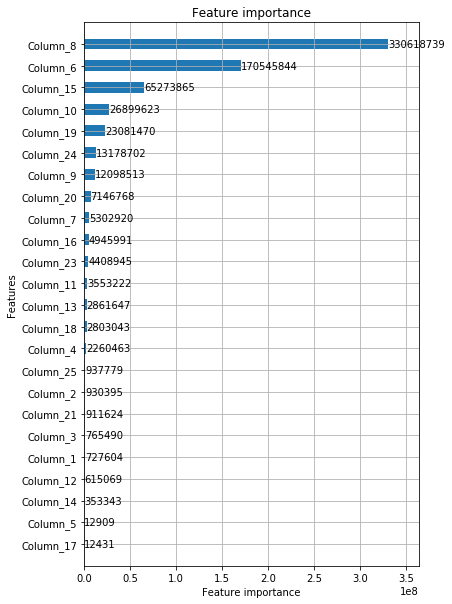

In [18]:
fit = fit_model(train_data, fake_valid_data)

In [19]:
def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

pred_to_csv(fit, test, x)

True